In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import sys
import os
sys.path.append(os.path.abspath(".."))  # if you're inside notebooks/

from scripts.news_utils import (
    load_news_data,
    parse_dates,
    filter_by_ticker,
    daily_article_counts,
    plot_daily_article_frequency
)

In [3]:
ticker = 'GOOG'
news_path = '../data/raw_analyst_ratings.csv'
stock_path = f'../data/yfinance_data/{ticker}_historical_data.csv'

# ------------------ Load & Preprocess News Data ------------------
df_news = load_news_data(news_path)
df_news = parse_dates(df_news)
df_news_aapl = filter_by_ticker(df_news, ticker)

print("\nGOOG News Data Info:")
print(df_news_aapl.info())


GOOG News Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1199 entries, 565380 to 566578
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   headline   1199 non-null   object             
 1   url        1199 non-null   object             
 2   publisher  1199 non-null   object             
 3   date       1199 non-null   datetime64[ns, UTC]
 4   stock      1199 non-null   object             
 5   date_only  1199 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 65.6+ KB
None


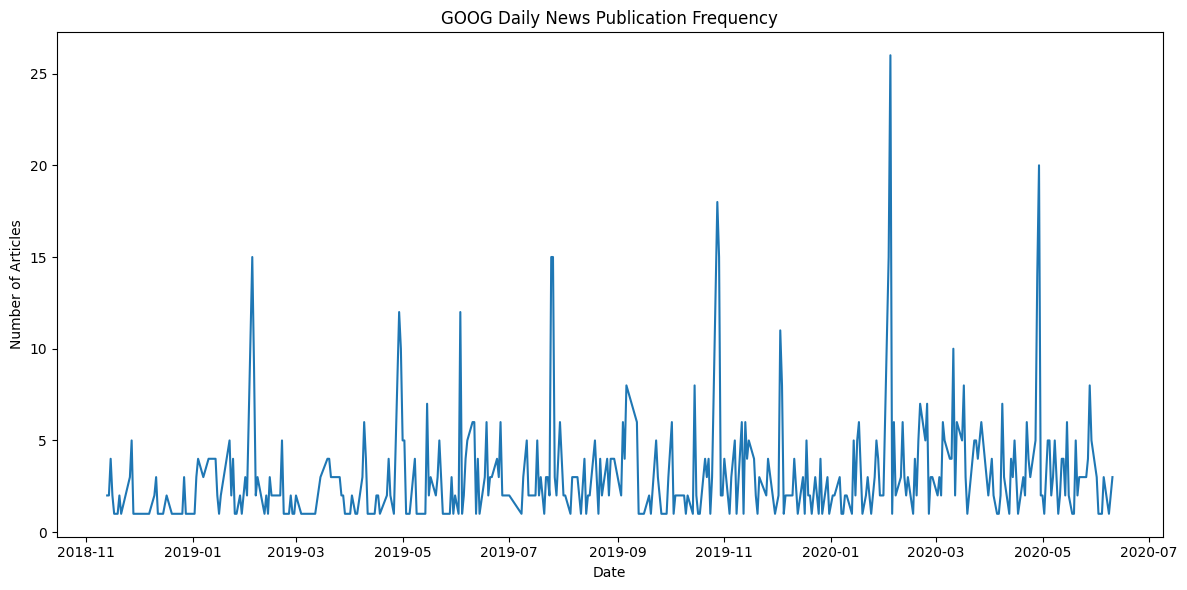


GOOG Stock Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1435 entries, 2018-11-13 to 2024-07-30
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1435 non-null   float64
 1   High          1435 non-null   float64
 2   Low           1435 non-null   float64
 3   Close         1435 non-null   float64
 4   Adj Close     1435 non-null   float64
 5   Volume        1435 non-null   int64  
 6   Dividends     1435 non-null   float64
 7   Stock Splits  1435 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 100.9 KB
None


In [5]:
# ------------------ Visualize News Frequency ------------------
daily_counts = daily_article_counts(df_news_aapl)
plot_daily_article_frequency(daily_counts, title=f'{ticker} Daily News Publication Frequency')

# ------------------ Load Stock Price Data ------------------
df_stock = pd.read_csv(stock_path)
df_news_aapl.loc[:, 'date'] = df_news_aapl['date'].apply(
    lambda x: x.tz_convert(None) if hasattr(x, 'tzinfo') and x.tzinfo is not None else x
)


df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace=True)
df_stock = df_stock[df_stock.index >= df_news_aapl['date'].min()]  # Align with news

print("\nGOOG Stock Data Info:")
print(df_stock.info())

In [6]:
# ------------------ Technical Indicators ------------------
df_stock['SMA_20'] = talib.SMA(df_stock['Close'], timeperiod=20)
df_stock['EMA_20'] = talib.EMA(df_stock['Close'], timeperiod=20)
df_stock['RSI'] = talib.RSI(df_stock['Close'], timeperiod=14)
df_stock['MACD'], df_stock['MACD_Signal'], df_stock['MACD_Hist'] = talib.MACD(
    df_stock['Close'], fastperiod=12, slowperiod=26, signalperiod=9
)

In [7]:
# ------------------ Financial Metrics ------------------
df_stock['Daily_Return'] = df_stock['Close'].pct_change() * 100
df_stock['Volatility'] = df_stock['Daily_Return'].rolling(window=20).std()


GOOG with Indicators and Metrics:
                 Close      SMA_20        RSI  Daily_Return      MACD  \
Date                                                                    
2024-07-24  174.369995  185.500001  37.434718     -5.027239 -0.034166   
2024-07-25  169.160004  184.689501  32.279082     -2.987894 -1.106693   
2024-07-26  168.679993  183.780501  31.843937     -0.283762 -1.972672   
2024-07-29  171.130005  183.166001  36.545844      1.452462 -2.433223   
2024-07-30  171.860001  182.534501  37.920068      0.426574 -2.708091   

            MACD_Signal  MACD_Hist  
Date                                
2024-07-24     1.571016  -1.605182  
2024-07-25     1.035474  -2.142167  
2024-07-26     0.433845  -2.406517  
2024-07-29    -0.139569  -2.293654  
2024-07-30    -0.653273  -2.054818  


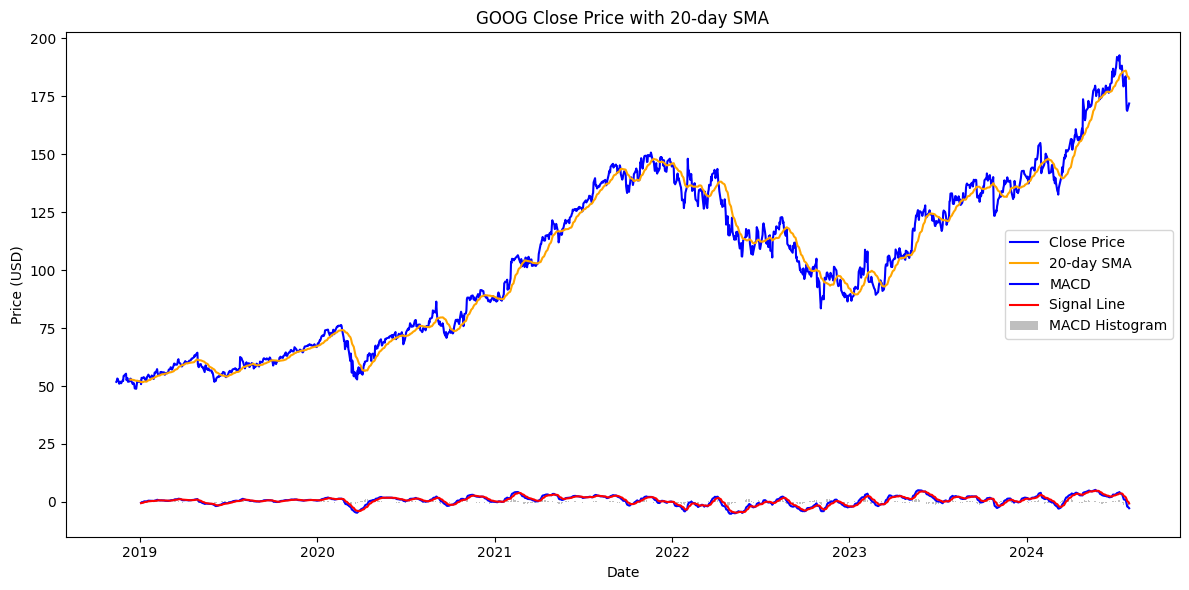

In [8]:
# ------------------ Inspect & Visualize ------------------
print("\nGOOG with Indicators and Metrics:")
print(df_stock[['Close', 'SMA_20', 'RSI', 'Daily_Return', 'MACD', 'MACD_Signal', 'MACD_Hist']].tail())


# Plot Close Price with SMA
plt.figure(figsize=(12, 6))
plt.plot(df_stock['Close'], label='Close Price', color='blue')
plt.plot(df_stock['SMA_20'], label='20-day SMA', color='orange')
plt.plot(df_stock.index, df_stock['MACD'], label='MACD', color='blue')
plt.plot(df_stock.index, df_stock['MACD_Signal'], label='Signal Line', color='red')
plt.bar(df_stock.index, df_stock['MACD_Hist'], label='MACD Histogram', color='gray', alpha=0.5)


plt.title(f'{ticker} Close Price with 20-day SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()